# K-Armed Bandits

This notebook contains annotations and exercises from the Coursera course and the book. It demonstrates the idea behind K-Armed Bandits, exploration-exploitation dilemma and Stationary vs non-Stationary policies

## The problem

You're repeatedly presented with a choice among k different options, or actions. After each choice you receive a numerical reward chosen from a stationary probability distribution that depends on the action you selected. Your objective is to maximize the expected total reward over some time period, for example over 1000 action selections, or time steps.(Stutton, 25)

## Implementing the situation

Let's create a toy example, from which we will apply all the concepts. We'll first start with a class for the k-Armed Bandit.

In [557]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Bandit implementation

We only need a pretty basic class, in which we can initialize each arm with a defined reward distribution. We also need to be able to sample an action-reward for each arm independently. This is how we're going to interact with it and determine the best action to maximize reward.

In [347]:
class Bandit:
    def __init__(self, k, batchsize=1, mean=0, stdev=1):
        self.k = k
        self.batchsize = batchsize
        self.arms_mean = stdev*np.random.randn(batchsize,k) + mean
        
    def pull(self, idx):
        return np.random.randn(self.batchsize) + self.arms_mean[np.arange(self.batchsize),idx]
    
    def optimal(self):
        return np.argmax(self.arms_mean, axis=1)


Let's see a working example of this class

In [348]:
ten_bandits = Bandit(10,5)

In [350]:
ten_bandits.pull(np.random.randint(5))

array([-1.25187937, -0.04727494, -0.98989179,  0.54381794, -0.15782044])

In [351]:
ten_bandits.optimal()

array([0, 8, 4, 5, 7])

### Agent Implementation

The agent needs to have an expected value for each of the possible actions it can take. It will use this information to try and determine the best course of action. It will also have as optional arguments a value epsilon and an array of k-size for the initial expected rewards for each arm.

Our agent must be able to choose an arm in accordance to the expected values, as well as update each expected value with the experience he receives

In [541]:
class Agent:
    def __init__(self, k, batchsize=1, epsilon=0, expected=None):
        self.k = k
        self.batchsize = batchsize
        self.n = np.zeros((batchsize, k)).astype(int) # Number of elapsed time-steps for each action. Will be updated every time we decide to update our expected rewards for each arm
        self.log = None # Store the total obtained reward as an array of entries. This will allow us to see how much reward it obtained over time
        self.epsilon = epsilon
        if expected is None:
            expected = np.zeros((batchsize, k)) # Default to zeros of size k
        assert list(expected.shape) == [batchsize,k], 'Expected values must have the same shape as the number of expected arms and batch size'
        self.expected = np.array(expected)
        
    def choose_action(self):
        # Return the index of the next arm to pull. This is done using argmax with probability 1-epsilon, and choosing randomly with probability epsilon
        
        # Define which type of desicion to take for each experiment. 1 means greedy action and 0 means random action
        choice_type = (np.random.random_sample((self.batchsize)) > self.epsilon).astype(int)
        
        random_actions = np.random.randint(self.k, size=self.batchsize)
        greedy_actions = np.argmax(self.expected + 0.1*np.random.random(self.expected.shape), axis=1)
        
        # Since the type of actions are mutually exclusive, we can add the combination of both actions
        return greedy_actions * choice_type + random_actions * (1 - choice_type)
        
    def update(self, action, reward):
        # Receives an action index to be updated and the amount of reward seen on the elapsed time-step
        self.n[np.arange(self.batchsize), action] += 1
        log_item = np.array([[action, reward]])
        if self.log is None:
            self.log = log_item
        else:
            # TODO SLOW
            self.log = np.concatenate((self.log, log_item), axis=0)
        n = self.n[np.arange(self.batchsize), action]
        self.expected[np.arange(self.batchsize), action] += (1/n)*(reward - self.expected[np.arange(self.batchsize), action])
        return self.expected
    

### First experiment: Greedy agent

In [559]:
def experiment(k, experiments, timesteps, epsilon=0, initial_expectation=None):
    a = Agent(k, experiments, epsilon, initial_expectation)
    b = Bandit(k, experiments)
    print("running experiment")
    for _ in range(timesteps):
        action = a.choose_action()
        reward = b.pull(action)
        a.update(action, reward)
        
    print("Done!")
    
    # plot the log in terms of how many times the optimal action was chosen
    actions_log = a.log[:,0]
    optimal = b.optimal()
    correct = (actions_log == optimal).astype(int)
    correct_percent = np.mean(correct, axis=1)
    return correct_percent
    

In this experiment, our agent will always choose the arm in which it has the greatest expected reward. This is an exploitation technique, in which no exploration is done unless there's a tie in the greatest expected rewards 

running experiment
Done!


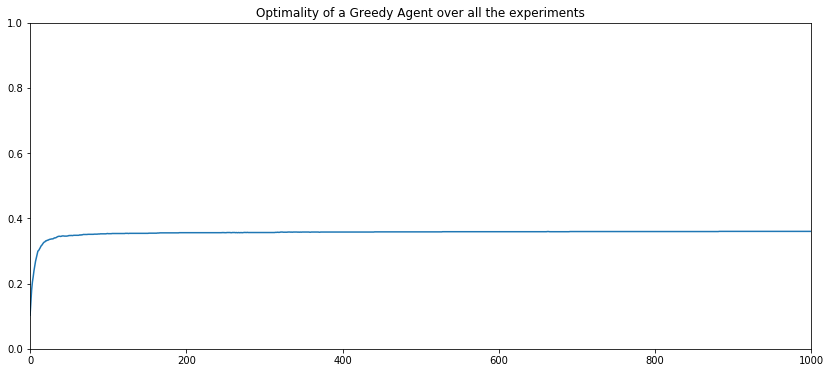

In [571]:
k = 10
experiments = 2000
timesteps = 1000

greedy_results = experiment(k, experiments, timesteps)
plt.figure(figsize=(14,6))
plt.title('Optimality of a Greedy Agent over all the experiments')
plt.ylim(0, 1)
plt.xlim(0,timesteps)
sns.lineplot(data=greedy_results)

### Second experiment: Epsilon-Greedy Agent

In this experiment, we'll start using our optional parameter: `epsilon`. This parameter has the intention of removing some of the greediness of our agent, by allowing him to choose some random action with a probability of `epsilon`. This allows us to balance the Exploitation/Exploration dilemma, by prioritizing high expected reward actions, while also giving a chance to our agent to explore and possibly find more optimal solutions.

Notice that the code is basically the same. The only difference is we're changing the epsilon parameter of our agent to a small value between 0 and 1. This value determines the probability of our agent taking a random exploratory action. In this specific scenario we've decided to use a probabilty of taking a random action of 10%

running experiment
Done!


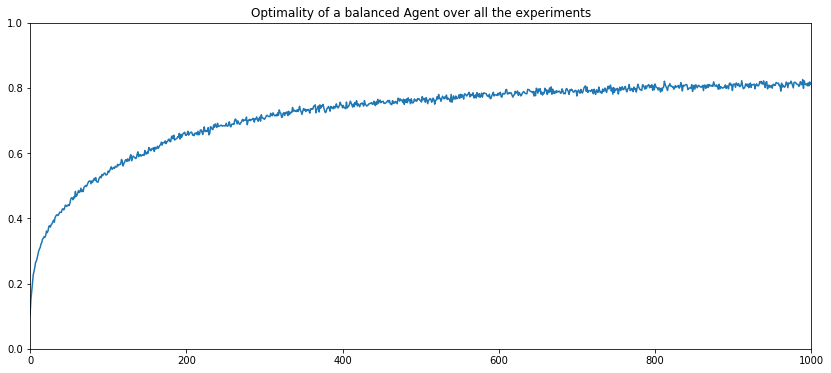

In [572]:
balanced_results = experiment(k, experiments, timesteps, 0.1)
plt.figure(figsize=(14,6))
plt.title('Optimality of a balanced Agent over all the experiments')
plt.ylim(0, 1)
plt.xlim(0,timesteps)
sns.lineplot(data=balanced_results)

Now this is looking promising. What happens if we decide to allow the agent to explore as much as he exploits? Let's set `epsilon` to 50%

running experiment
Done!


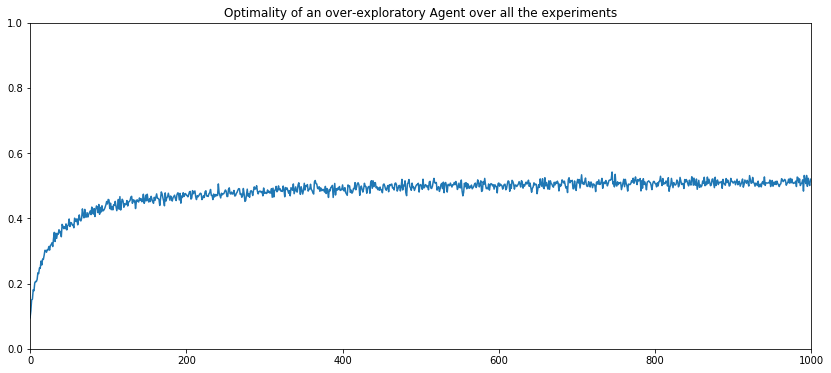

In [573]:
exploratory_results = experiment(k, experiments, timesteps, 0.5)
plt.figure(figsize=(14,6))
plt.title('Optimality of an over-exploratory Agent over all the experiments')
plt.ylim(0, 1)
plt.xlim(0,timesteps)
sns.lineplot(data=exploratory_results)

Lastly, what if we decide to still exploit way more than explore, while still allowing our agent to explore a little bit? Let's test an epsilon of 1%

running experiment
Done!


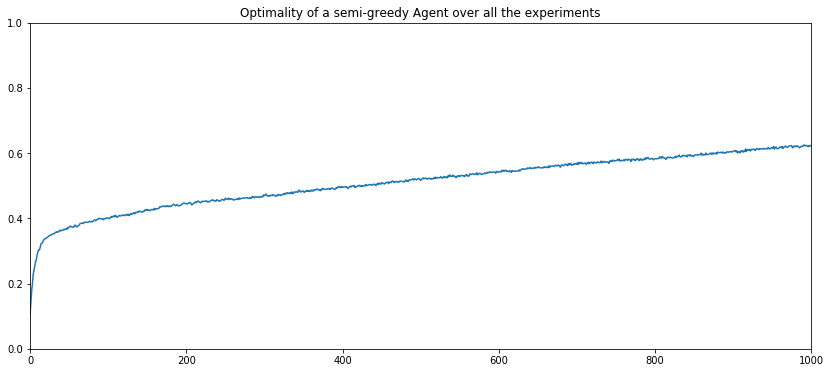

In [574]:
semigreedy_results = experiment(k, experiments, timesteps, 0.01)
plt.figure(figsize=(14,6))
plt.title('Optimality of a semi-greedy Agent over all the experiments')
plt.ylim(0, 1)
plt.xlim(0,timesteps)
sns.lineplot(data=semigreedy_results)

We can see that the epsilon value really does change the results quite a lot. To make it clearer, let's plot all of the results together

[Text(0, 0.5, 'Optimality percentage'), Text(0.5, 0, 'Time Steps')]

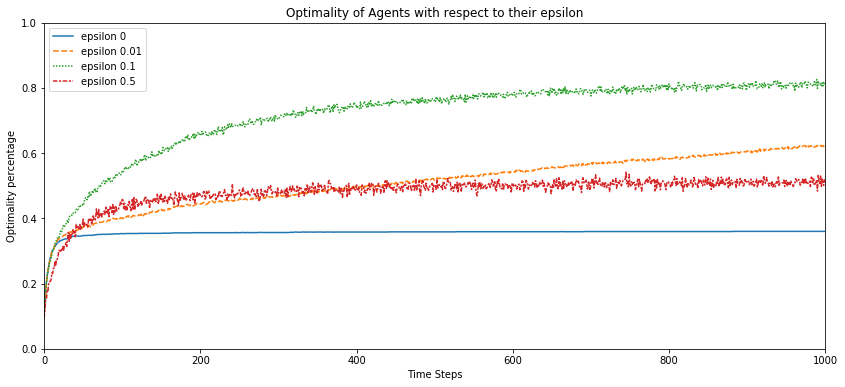

In [575]:
results_df = pd.DataFrame({
    'epsilon 0': greedy_results, 
    'epsilon 0.01': semigreedy_results, 
    'epsilon 0.1': balanced_results,
    'epsilon 0.5': exploratory_results
})

plt.figure(figsize=(14,6))
plt.title('Optimality of Agents with respect to their epsilon')
plt.ylim(0, 1)
plt.xlim(0,timesteps)
ax = sns.lineplot(hue='event', style='event',data = results_df)
ax.set(xlabel='Time Steps', ylabel='Optimality percentage')

This results show that there must be a balance when deciding what epsilon to choose. An epsilon of 0 doesn't allow our agent to explore enough, and will most frequently get stuck in a sub-optimal solution. A really low epsilon (0.01) will allow our agent to explore, but convergence is slow. If given enough timesteps, it could find a great solution, but sometimes that amount of time is unfeasable. A really high epsilon on the other hand doesn't give our agent the opportunity to really exploit what it has learned from all the exploration it has taken.